# Creating Contrast Curves - 30

This notebook performs an analysis of contrast in PSF-Subtracted images. This process is done in a few simple steps:   

1) Fake planets are injected into the given dataset.  

2) pyKLIP is used to subtract the PSF of the star in the data.  

3) The fake planets are retrieved, and their post-klip flux values are measured.  

4) Contrast curves are created.

In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pyklip.klip
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes

### Loading the dataset

In [2]:
#Import the dataset to be used
filtername = "f300m"

# read in roll 1
with fits.open("old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data

# read in roll 2
with fits.open("old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data  

# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)/2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

#Define dataset
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False

### Reading in and centering the unocculted psf

In [3]:
# read in unocculted PSF
with fits.open("old_simulated_data/NIRCam_unocculted_{0}.fits".format(filtername)) as hdulist:
    psf_cube = hdulist[0].data 
    psf_head = hdulist[0].header
    print(psf_cube.shape)   
    
# collapse reference psf in time
psf_frame = np.nanmean(psf_cube, axis=0)

# find the centroid
bestfit = fakes.gaussfit2d(psf_frame, 71, 30, searchrad=3, guessfwhm=2, guesspeak=1, refinefit=True)

psf_xcen, psf_ycen = bestfit[2:4]
print(psf_xcen, psf_ycen)

# recenter PSF to that location
x, y = np.meshgrid(np.arange(-20,20.1,1), np.arange(-20,20.1,1))
x += psf_xcen
y += psf_ycen

psf_stamp = scipy.ndimage.map_coordinates(psf_frame, [y,x])
print(psf_stamp.shape)

(6, 101, 101)
70.45855749153525 29.8360856033007
(41, 41)


### Specifying the parameters of the fake planet/s to be injected

In [4]:
#Specify the desired contrasts of the fake planets' flux
input_contrast = 1e-2
input_contrasts = [input_contrast for i in range(30)]
planet_seps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,  28, 29, 30]
planet_fwhm = 3.5

#making more psf stamps
psf_stamp = np.array([psf_stamp for i in range(12)])
print(psf_stamp.shape)

#Defining angle of injected fakes in CCW angle from +x axis to +y axis
thetas_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]
thetas_array = []
for theta_value in thetas_values:
    these_thetas = np.ones(12)*theta_value
    these_thetas = these_thetas - dataset.PAs
    thetas_array.append(these_thetas)

(12, 41, 41)


## Inject the fake planets

In [5]:
for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas_array):
#Multiply unocculted psf by desired contrast level to simulate planet psf
    planet_fluxes = psf_stamp*input_contrast

    fakes.inject_planet(frames = dataset.input, 
                        centers=dataset.centers, 
                        inputflux=planet_fluxes, 
                        astr_hdrs=dataset.wcs, 
                        radius=planet_sep,
                        pa = None,
                        thetas = theta)

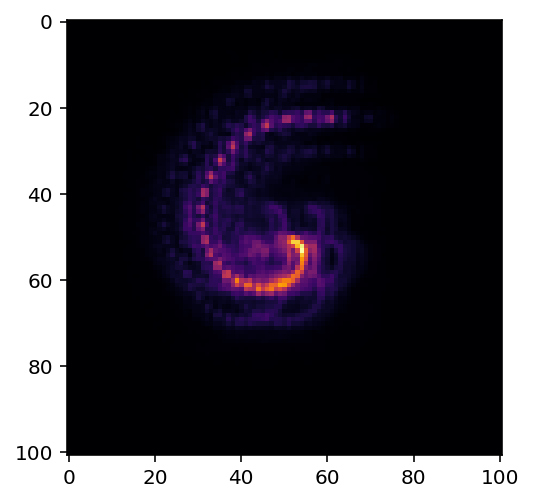

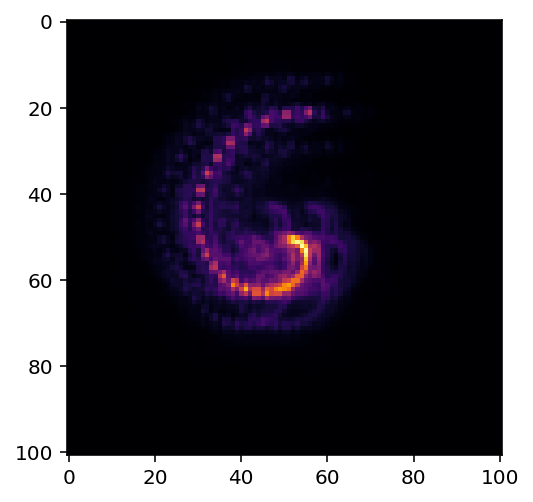

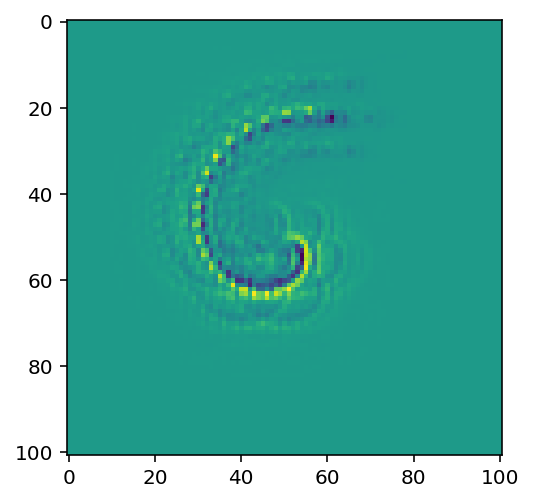

In [6]:
#Image with fakes injected before KLIP
plt.imshow(dataset.input[2], cmap = 'inferno')

plt.figure()
plt.imshow(dataset.input[8], cmap = 'inferno')

plt.figure()
plt.imshow(dataset.input[8] - dataset.input[2])

## Run pyKLIP on injected fakes

In [7]:
#Set output directory
outputdir = 'contrastcurves'
fileprefix = 'FAKE_KLIP_ADI_A9K5S4M1'
numbasis = [1,5,10,20,50]


#Run KLIP on dataset with injected fakes
parallelized.klip_dataset(dataset, 
                          outputdir=outputdir, 
                          fileprefix=fileprefix, 
                          algo = 'klip', 
                          annuli=9, 
                          subsections=4, 
                          movement=1, 
                          numbasis=numbasis, 
                          mode="ADI")

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 36
27.78% done (9/36 completed)
55.56% done (19/36 completed)
83.33% done (29/36 completed)
Closing threadpool
Derotating Images...
Writing Images to directory /Users/jeaadams/JWST_PIPE/notebooks/contrastcurves


/Users/jeaadams/Follete-group/Follette-group/wrapperUpdate/pyklip/pyklip/parallelized.py:1561: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(pixel_weights * dataset.output, axis=(1,2))


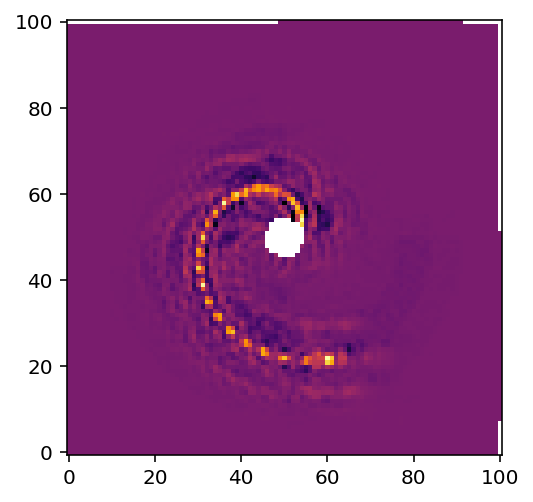

In [8]:
# Open the fits file created
with fits.open("contrastcurves/FAKE_KLIP_ADI_A9K5S4M1-KLmodes-all.fits") as hdulist:
    adi_cube = hdulist[0].data
    
#Plot the result of KLIP
plt.figure()
# plot the KL20 Cube (index of 3)
plt.imshow(adi_cube[2], interpolation='nearest', cmap = 'inferno')
plt.gca().invert_yaxis()

## Read in the fits file created by KLIP

In [9]:
#reading in collapsed fits file at the first KL mode
with fits.open("contrastcurves/FAKE_KLIP_ADI_A9K5S4M1-KLmodes-all.fits") as hdulist:
    outputfile = hdulist[0].data
    outputfile_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]

In [10]:
#Collapse along KL modes (0th axis)
outputfile_frame = np.nanmean(outputfile, axis=0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [11]:
#Create an empty list to store retrieved planet fluxes
retrieved_planet_fluxes = []

    
#retrieving planet flux
for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas_values):
  


    fake_flux = fakes.retrieve_planet_flux(frames = outputfile_frame, 
                                            centers=outputfile_centers,
                                            astr_hdrs=dataset.wcs[0], 
                                            sep=planet_sep,
                                            pa = None,
                                            thetas = theta,
                                            searchrad = 7) 

    retrieved_planet_fluxes.append(fake_flux)

In [12]:
#retrieve fluxes of injected planets
retrieved_unocculted_fluxes = []

for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas_array):

    flux_unocc = fakes.retrieve_planet_flux(frames = dataset.input, 
                        centers=dataset.centers,  
                        astr_hdrs=dataset.wcs, 
                        sep=planet_sep,
                        pa = None,
                        thetas = theta)
    retrieved_unocculted_fluxes.append(flux_unocc)

In [13]:
#Find the median of the retrieved unocculted fluxes
avg_unocc_flux = np.median(retrieved_unocculted_fluxes)

## Compute throughput

In [14]:
#Reminder to create unit test to make sure througput less than injected flux

#multiply the by unocculted psf (normalize)
#run retrieve planet flux on the original unocculted psf to get actual flux meas
#and then divide.  should just be one number

#Isn't it supposed to be "planet_flux" in the denominator?
throughput = np.array(retrieved_planet_fluxes)/avg_unocc_flux
print("Retrieved fluxes are " + str(retrieved_planet_fluxes))
print()
print("Throughput is "+ str(throughput))

Retrieved fluxes are [0.0, 3.1306104468227924, -1.9479493146955706e-63, 210.8029376147742, 2841.908571354708, 2934.495894451449, 2493.5668412801247, 2141.2071817344104, 2440.409730836856, 1301.3725111787764, 1962.6200098092106, 2517.0541846121314, 2451.189120390669, 2663.2640000788965, 3065.8166692551677, 2894.748307842955, 2163.6599710883206, 710.2390984852941, 2506.3271666490973, 2467.864557059712, 2625.6847027313997, 2833.693327233875, 2520.914694595052, 2549.7844111157433, 2716.9425052170454, 2238.6201941802065, 2547.1913958492055, 2321.7672297367703, 2095.3855253659726, 3507.164549323654]

Throughput is [ 0.00000000e+00  5.11967980e-04 -3.18560132e-67  3.44739009e-02
  4.64754787e-01  4.79896162e-01  4.07788322e-01  3.50164779e-01
  3.99095212e-01  2.12821451e-01  3.20959321e-01  4.11629351e-01
  4.00858032e-01  4.35539942e-01  5.01371856e-01  4.73395994e-01
  3.53836622e-01  1.16149768e-01  4.09875096e-01  4.03585069e-01
  4.29394368e-01  4.63411298e-01  4.12260684e-01  4.1698192

## Make Contrast Curves

In [15]:
OWA = 65 #Setting this to be distance between star and outer edge of image
FWHM = 3.5

#Measuring the contrast in the image
contrast_seps, contrast = pyklip.klip.meas_contrast(dat = outputfile_frame, 
                                                     iwa = dataset.IWA, 
                                                     owa = OWA, 
                                                     resolution = FWHM, 
                                                     center = outputfile_centers,
                                                     low_pass_filter = False)

Text(0.5,0,'Planet Separation')

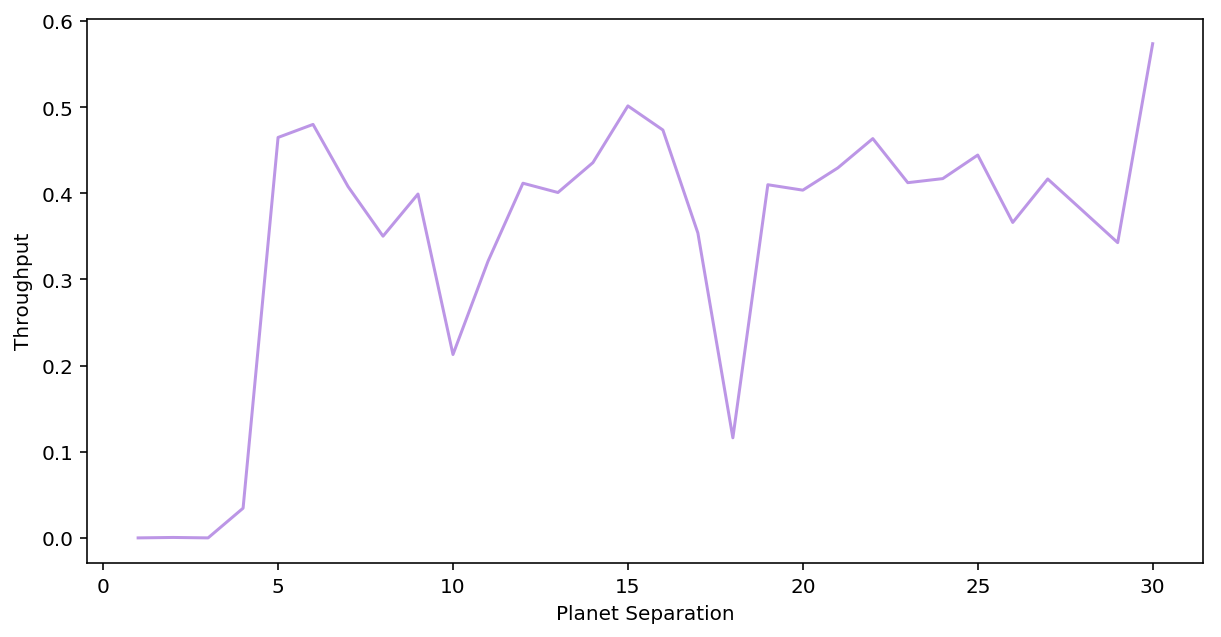

In [16]:
plt.figure(figsize = (10,5))
plt.plot(planet_seps, throughput, color = '#BC96E6')
plt.ylabel("Throughput")
plt.xlabel("Planet Separation")